In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from binance.client import Client
from scipy.optimize import brute

In [2]:
api_key = "bT3JgDAiGkPkIDzVAGNXvRrLU5PePQz0kNz2Gtt8NFAatjfOOIiVoiMhjOk4t9RL"
secret_api_key = "IdrL486SQzb5QB5ruuakUZZdKwgTNGGEzM1VHQ6QPDSpZawrGCemjV1LNfOYCjWj"
client = Client(api_key=api_key, api_secret=secret_api_key, tld="com")

In [3]:
class EMA_SMA_CROSSOVER_BACKTESTER():
    
    def __init__(self, client, symbol, EMA, SMA, train_start=None, train_end=None,
                test_start=None, test_end=None, interval="1h"):
        
        self.symbol = symbol
        self.interval = interval
        self.EMA = EMA
        self.SMA = SMA
        self.train_start = train_start
        self.train_end = train_end
        self.test_start = test_start
        self.test_end = test_end
        self.results = None
        self.get_data()
    def get_data(self):
        import os.path
        if os.path.isfile("{}_{}.csv".format(self.symbol, self.interval)):
            raw = pd.read_csv("{}_{}.csv".format(self.symbol, self.interval), parse_dates=[0])
            raw.set_index("date", inplace=True)
        else:
            timestamp = client._get_earliest_valid_timestamp(symbol=self.symbol, interval=self.interval)
            timestamp = str(pd.to_datetime(timestamp, unit="ms"))
            raw = client.get_historical_klines(symbol=self.symbol, start_str=timestamp, interval=self.interval)
            raw = pd.DataFrame(raw)
            raw.drop(list(range(6,12,1)), axis=1, inplace=True)
            column_names = ["date","open", "high","low","close","volume"]
            raw.columns = column_names
            raw["date"] = pd.to_datetime(raw["date"], unit="ms")
            raw.set_index("date", inplace=True)
            for col in raw.columns:
                raw[col] = pd.to_numeric(raw[col])
            raw.to_csv("{}_{}.csv".format(self.symbol, self.interval))
        self.train_data = raw.loc[self.train_start:self.train_end].copy()
        self.test_data = raw.loc[self.test_start:self.test_end]
    def ema_strategy(self, test=False):
        if not test:
            self.data = self.train_data.copy()
        else:
            self.data = self.test_data.copy()
        self.data["returns"] = np.log(self.data.close.pct_change() + 1)
        self.data["creturns"] = self.data.returns.cumsum().apply(np.exp)
        self.data["EMA"] = self.data.close.ewm(span=self.EMA, min_periods=self.EMA).mean()
        self.data["SMA"] = self.data.close.rolling(window=self.SMA).mean()
        self.data.dropna(inplace=True)
        self.data["position"] = np.where(self.data["EMA"] > self.data["SMA"], 1, -1)
        self.data["strategy"] = self.data.position.shift() * self.data.returns
        self.data["trades"] = self.data.position.diff().fillna(0).abs()
        tc = 0.0012
        self.data["strategy_wtc"] = self.data.strategy - self.data["trades"] * tc
        self.data["cstrategy_wtc"] = self.data.strategy_wtc.cumsum().apply(np.exp)
    def plot_results(self):
        self.data[["creturns", "cstrategy_wtc"]].plot(figsize=(15,8), fontsize=13)
        plt.legend(fontsize=13)
    def result_df(self):
        return self.data
    def update_and_run(self, sma_r, test=False):
        self.EMA = sma_r[0]
        self.SMA = sma_r[1]
        self.ema_strategy(test=test)
        sharpe = (self.data.strategy_wtc.mean() * 365.25) / (self.data.strategy_wtc.std() * np.sqrt(365.25))
        return -sharpe
    def optimize_parameters(self, ema_range , sma_range):
        opt = brute(self.update_and_run, (ema_range, sma_range), finish=None)
        return opt

In [37]:
tester = EMA_SMA_CROSSOVER_BACKTESTER(client=client, symbol="ETHUSDT",
                                      EMA=45, SMA=79,
                                      train_end = "2022-06-13",
                                      test_start="2022-06-13",
                                      interval="1h")

In [38]:
tester.ema_strategy()

In [39]:
tester.result_df()

,open,high,low,close,volume,returns,creturns,EMA,SMA,position,strategy,trades,strategy_wtc,cstrategy_wtc
date,,,,,,,,,,,,,,
2017-08-20 10:00:00,295.97,296.89,293.43,295.51,24.83550,-0.001522,0.979775,293.252893,297.813797,-1,NaN,0.0,NaN,NaN
2017-08-20 11:00:00,292.59,295.51,292.59,295.00,51.53645,-0.001727,0.978084,293.331086,297.730127,-1,0.001727,0.0,0.001727,1.001729
2017-08-20 12:00:00,295.00,296.92,294.29,296.92,57.35344,0.006487,0.984450,293.491507,297.651899,-1,-0.006487,0.0,-0.006487,0.995251
2017-08-20 13:00:00,296.39,296.39,292.28,293.41,6.09547,-0.011892,0.972813,293.487868,297.534557,-1,0.011892,0.0,0.011892,1.007157
2017-08-20 14:00:00,294.25,294.25,294.25,294.25,3.90000,0.002859,0.975598,293.521853,297.361013,-1,-0.002859,0.0,-0.002859,1.004282
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-06-13 19:00:00,1231.91,1237.62,1217.84,1228.69,51378.86790,-0.002609,4.073771,1371.106710,1489.575190,-1,0.002609,0.0,0.002609,1300.963828
2022-06-13 20:00:00,1228.69,1284.33,1228.12,1242.17,72581.09510,0.010911,4.118464,1365.500766,1483.416582,-1,-0.010911,0.0,-0.010911,1286.845798
2022-06-13 21:00:00,1242.17,1248.55,1222.50,1229.60,32835.30590,-0.010171,4.076788,1359.592037,1476.974557,-1,0.010171,0.0,0.010171,1300.001013


In [40]:
tester.result_df().trades.value_counts()

0.0    41501
2.0      578
Name: trades, dtype: int64

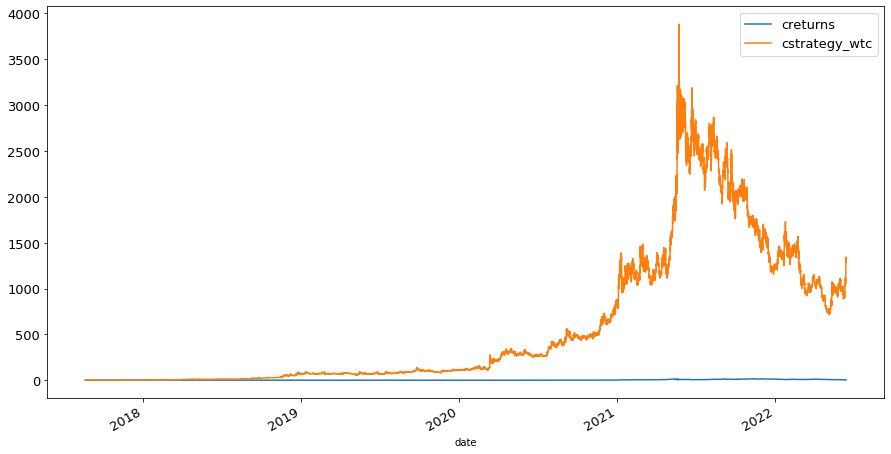

In [41]:
tester.plot_results()

In [46]:
tester.optimize_parameters((10,200,1),(10,200,1))

array([176., 198.])

In [49]:
tester.update_and_run((176,198), test=True)

-0.04430753610262293

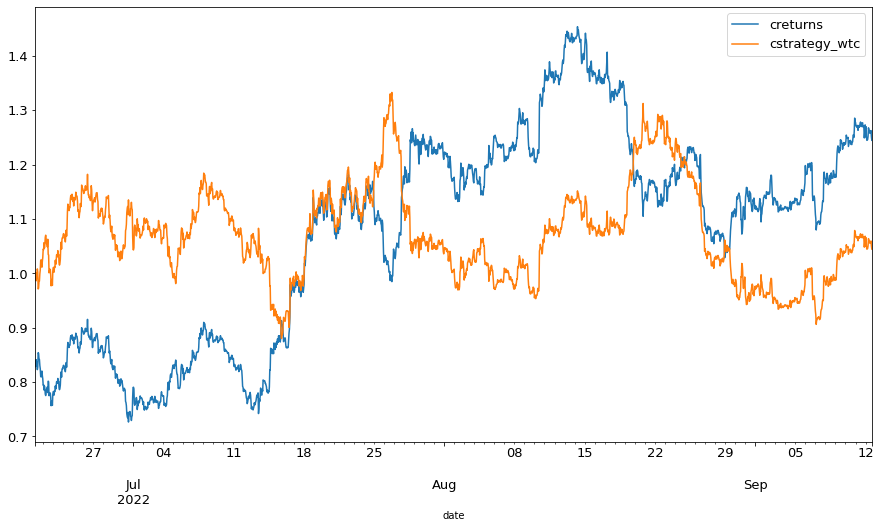

In [50]:
tester.plot_results()